In [11]:
import numpy as np
import os
from PIL import Image
from pathlib import Path 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Please write the optimal hyperparameter values you obtain in the global variable 'optimal_hyperparm' below. This
# variable should contain the values when I look at your submission. I should not have to run your code to populate this
# variable.
optimal_hyperparam = {}

class COC131:
    def q1(self, filename=None):
        
        """
        This function should be used to load the data. To speed-up processing in later steps, lower resolution of the
        image to 32*32. The folder names in the root directory of the dataset are the class names. After loading the
        dataset, you should save it into an instance variable self.x (for samples) and self.y (for labels). Both self.x
        and self.y should be numpy arrays of dtype float.
    
        :param filename: this is the name of an actual random image in the dataset. You don't need this to load the
        dataset. This is used for testing the implementation.
        :return res1: a one-dimensional numpy array containing the flattened low-resolution image in file 'filename'.
        Flatten the image in the row major order. The dtype for the array should be float.
        :return res2: a string containing the class name for the image in file 'filename'. This string should be the same as
        one of the folder names in the originally shared dataset.
        """
    
        # Get all subfolders within the dataset directory
        subfolders = [entry.path for entry in os.scandir("../dataset") if entry.is_dir()]
    
        # Creates a list of all paths for the images stored within the ../dataset directory
        image_paths = [os.path.join(subfolder, file)
                     for subfolder in subfolders
                     for file in os.listdir(subfolder) if file.endswith(('.jpg'))] # If the file is an image
    
        # Processes each image within the dataset directory and stores it into the images array
        self.x = np.array([np.array(Image.open(image_path).resize((32, 32)), dtype=float).flatten() for image_path in image_paths])
    
        # Gets the name of the folder that the image is stored in (the classification of the image)
        self.y = np.array([os.path.basename(os.path.dirname(image_path)) for image_path in image_paths])
    
        # If a filename is provided, find and return it
        if filename:
            matching_image_path = next((image_path for image_path in image_paths if filename in image_path), None)
            
            if matching_image_path:
                res1 = np.array(Image.open(matching_image_path).resize((32, 32)), dtype=float).flatten()
                res2 = os.path.basename(os.path.dirname(matching_image_path))  # Extract class name
                return res1, res2
                
        return self.x, self.y
    
    def q2(self, inp):
        """
        This function should compute the standardized data from a given 'inp' data. The function should work for a
        dataset with any number of features.

        :param inp: an array from which the standardized data is to be computed.
        :return res2: a numpy array containing the standardized data with standard deviation of 2.5. The array should
        have the same dimensions as the original data
        :return res1: sklearn object used for standardization.
        """

        standard_scaler = StandardScaler() # Creates a sklearn object used for standardisation
        standardised_data = standard_scaler.fit_transform(inp) # Standardises the data (setting the standard deviation to 1)

        res1 = standard_scaler
        res2 = standardised_data * 2.5 # Standardises the data to have a standard deviation of 2.5

        return res2, res1
    
    @staticmethod
    def visualise_standardisation(original_data, standardised_data):
         
         """
         Visualises original and standardised data side by side using boxplots.
         :param original_data: numpy array of original dataset
         :param standardised_data: numpy array of standardised dataset
         """
         fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
         axs[0].boxplot(original_data, vert=True)
         axs[0].set_title("Original Data Distribution")
         axs[0].set_xlabel("Features")
         axs[0].set_ylabel("Value")
    
         axs[1].boxplot(standardised_data, vert=True)
         axs[1].set_title("Standardised Data Distribution (std = 2.5)")
         axs[1].set_xlabel("Features")
         axs[1].set_ylabel("Value")
         
    
         plt.tight_layout()
         plt.show()
        
    @staticmethod
    def visualise_hyperparam_results(param_labels, cv_scores):
        """
        Generates a horizontal bar chart to visualise cross-validation accuracy 
        for each hyperparameter combination.
        """
        plt.figure(figsize=(12, 6))
        plt.barh(param_labels, cv_scores, color='skyblue')
        plt.xlabel("Mean Cross-Validation Accuracy")
        plt.title("Hyperparameter Optimisation Results")
        plt.gca().invert_yaxis()
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    def q3(self, test_size=None, pre_split_data=None, hyperparam=None):
        """
        Trains an MLPClassifier on a dataset, optionally performs hyperparameter optimisation,
        and visualises the results.
        """
        if self.scaler is None:
            self.x, self.scaler = self.q2(self.x)
    
        if test_size is None:
            test_size = 0.3
    
        if pre_split_data:
            x_train, x_test, y_train, y_test = pre_split_data
        else:
            x_train, x_test, y_train, y_test = train_test_split(self.x, self.y, test_size=test_size, random_state=1)
    
        if hyperparam:
            model = MLPClassifier(**hyperparam, random_state=1)
            model.fit(x_train, y_train)
            self.best_hyperparams = hyperparam
        else:
            param_grid = {
                "hidden_layer_sizes": [(50,), (100,), (100, 50), (200,)],
                "learning_rate": ["constant", "adaptive"],
                "solver": ["adam", "sgd"]
            }
    
            grid_search = GridSearchCV(
                MLPClassifier(random_state=1),
                param_grid,
                cv=3
            )
            grid_search.fit(x_train, y_train)
    
            # Visualisation step
            param_labels = [str(p) for p in grid_search.cv_results_["params"]]
            cv_scores = grid_search.cv_results_["mean_test_score"]
            visualise_hyperparam_results(param_labels, cv_scores)
    
            model = grid_search.best_estimator_
            self.best_hyperparams = grid_search.best_params_
    
        loss_curve = np.array(model.loss_curve_) if hasattr(model, "loss_curve_") else np.array([])
        train_accuracy = np.array([accuracy_score(y_train, model.predict(x_train))])
        test_accuracy = np.array([accuracy_score(y_test, model.predict(x_test))])
    
        return model, loss_curve, train_accuracy, test_accuracy
    
    def q4(self):
        """
        This function should study the impact of alpha on the performance and parameters of the model. For each value of
        alpha in the list below, train a separate MLPClassifier from scratch. Other hyperparameters for the model can
        be set to the best values you found in 'q3'. You can assume that the function 'q1' has been called
        prior to calling this function.

        :return: res should be the data you visualized.
        """
    
        # Train/test split (same as q3)
        x_train, x_test, y_train, y_test = train_test_split(self.x, self.y, test_size=0.3, random_state=1)
    
        # Alpha values to test
        alpha_values = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 50, 100]
    
        train_accuracies = []
        test_accuracies = []
    
        # Train a model for each alpha value
        for alpha in alpha_values:
            # Use best hyperparameters from q3(), but override alpha
            hyperparams = self.best_hyperparams.copy()
            hyperparams["alpha"] = alpha
    
            model = MLPClassifier(**hyperparams, random_state=1)
            model.fit(X_train, y_train)
    
            # Evaluate model
            train_acc = accuracy_score(y_train, model.predict(x_train))
            test_acc = accuracy_score(y_test, model.predict(x_test))
    
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
    
            # Model parameters
            weights = model.coefs_
            biases = model.intercepts_

            total_w = sum(w.size for w in weights)
            total_b = sum(b.size for b in biases)
    
            total_weights.append(total_w)
            total_biases.append(total_b)

        # Store results in a dictionary
        res = {
        "alpha_values": alpha_values,
        "train_accuracies": train_accuracies,
        "test_accuracies": test_accuracies,
        "total_weights": total_weights,
        "total_biases": total_biases,
        }
        return res
    

    @staticmethod
    def visualise_alpha_impact(res):
         
        """
        Visualises how alpha (regularisation strength) affects model performance and parameters.
        
        : param res: Dictionary output from q4() containing accuracy and parameter data.
        """
        alphas = res["alpha_values"]
        train_acc = res["train_accuracies"]
        test_acc = res["test_accuracies"]
        weights = res["total_weights"]
        biases = res["total_biases"]
    
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
        # Plot Accuracy vs Alpha
        axs[0].plot(alphas, train_acc, marker='o', label='Train Accuracy')
        axs[0].plot(alphas, test_acc, marker='s', label='Test Accuracy')
        axs[0].set_xscale('log')
        axs[0].set_xlabel("Alpha (L2 Regularization Strength)")
        axs[0].set_ylabel("Accuracy")
        axs[0].set_title("Effect of Alpha on Model Accuracy")
        axs[0].legend()
        axs[0].grid(True, linestyle='--', alpha=0.6)
    
        # Plot Parameters vs Alpha
        axs[1].plot(alphas, weights, marker='o', label='Total Weights')
        axs[1].plot(alphas, biases, marker='s', label='Total Biases')
        axs[1].set_xscale('log')
        axs[1].set_xlabel("Alpha (L2 Regularisation Strength)")
        axs[1].set_ylabel("Parameter Count")
        axs[1].set_title("Effect of Alpha on Model Parameters")
        axs[1].legend()
        axs[1].grid(True, linestyle='--', alpha=0.6)
    
        plt.tight_layout()
        plt.show()
    

    def q5(self):
        """
        This function performs hypothesis testing to study the impact of using CV with and without Stratification
        on the performance of MLPClassifier. Set other model hyperparameters to the best values obtained in the previous
        questions. Use 5-fold cross validation for this question. You can assume that the function 'q1' has been called
        prior to calling this function.
    
        :return: The function returns 4 items - the final testing accuracy for both methods of CV, p-value of the
                 test and a string representing the result of hypothesis testing. The string can have only two possible values:
                 'Splitting method impacted performance' or 'Splitting method had no effect'.
        """
    
        # Use best hyperparameters from q3()
        hyperparams = self.best_hyperparams.copy()
    
        # Define the model
        model = MLPClassifier(**hyperparams, random_state=1)
    
        # Define 5-Fold CV (Without Stratification)
        kf = KFold(shuffle=True, random_state=1)
        cross_value_scores_kf = cross_val_score(model, self.x, self.y, cv=kf, n_jobs=-1)
    
        # Define 5-Fold Stratified CV
        skf = StratifiedKFold(shuffle=True, random_state=1)
        cross_value_scores_skf = cross_val_score(model, self.x, self.y, cv=skf, n_jobs=-1)
    
        # Compute mean testing accuracy
        mean_accuracy_kf = np.mean(cv_scores_kf)
        mean_accuracy_skf = np.mean(cv_scores_skf)
    
        # Perform paired t-test to compare distributions
        t_stat, p_value = ttest_rel(cv_scores_kf, cv_scores_skf)
    
        # Determine hypothesis test result
        alpha = 0.05  # Significance level
        if p_value < alpha:
            hypothesis_result = "Splitting method impacted performance"
        else:
            hypothesis_result = "Splitting method had no effect"
    
        return mean_acc_kf, mean_acc_skf, p_value, hypothesis_result

    
    @staticmethod
    def visualise_cv_comparison(scores_kf, scores_skf):
        """
        Plots a boxplot comparing performance between K-Fold and Stratified K-Fold cross-validation.
    
        :param scores_kf: List or array of accuracy scores from K-Fold CV
        :param scores_skf: List or array of accuracy scores from Stratified K-Fold CV
        """
        data = [scores_kf, scores_skf]
        labels = ['K-Fold CV', 'Stratified K-Fold CV']
    
        plt.figure(figsize=(8, 5))
        plt.boxplot(data, labels=labels, patch_artist=True,
                    boxprops=dict(facecolour='lightblue'),
                    medianprops=dict(colour='black'))
        plt.title('Cross-Validation Accuracy Comparison')
        plt.ylabel('Accuracy')
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
        
    def q6(self):
        """
        This function performs unsupervised learning using LocallyLinearEmbedding in sklearn to reduce the dataset
        to 2 dimensions. It returns the embedded data and corresponding labels to enable visualisation of class separability.
    
        :return: Dictionary containing 2D embedded data and class labels.
        """
    
        if self.x is None or self.y is None:
            raise ValueError("Dataset not loaded. Please call q1() first.")
    
        # Apply LLE with custom n_neighbors, but default 2D output
        lle = LocallyLinearEmbedding(n_neighbors=10, random_state=1)
        embedded_data = lle.fit_transform(self.x)
    
        res = {
            "embedded_data": embedded_data,
            "labels": self.y
        }
    
        return res

    @staticmethod
    def visualise_lle_separability(embedded_data, labels):
        """
        Plots a 2D scatterplot of the LLE embedded data, coloured by class.
    
        :param embedded_data: 2D numpy array from LLE
        :param labels: Class labels corresponding to each point
        """
        labels = np.array(labels)
        unique_classes = np.unique(labels)
        colours = plt.cm.get_cmap('tab10', len(unique_classes))
    
        plt.figure(figsize=(10, 7))
        for i, cls in enumerate(unique_classes):
            idx = labels == cls
            plt.scatter(embedded_data[idx, 0], embedded_data[idx, 1],
                        label=cls, alpha=0.7, s=30, c=[colours(i)])
    
        plt.title("2D Class Visualisation Using Locally Linear Embedding")
        plt.xlabel("LLE Dimension 1")
        plt.ylabel("LLE Dimension 2")
        plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

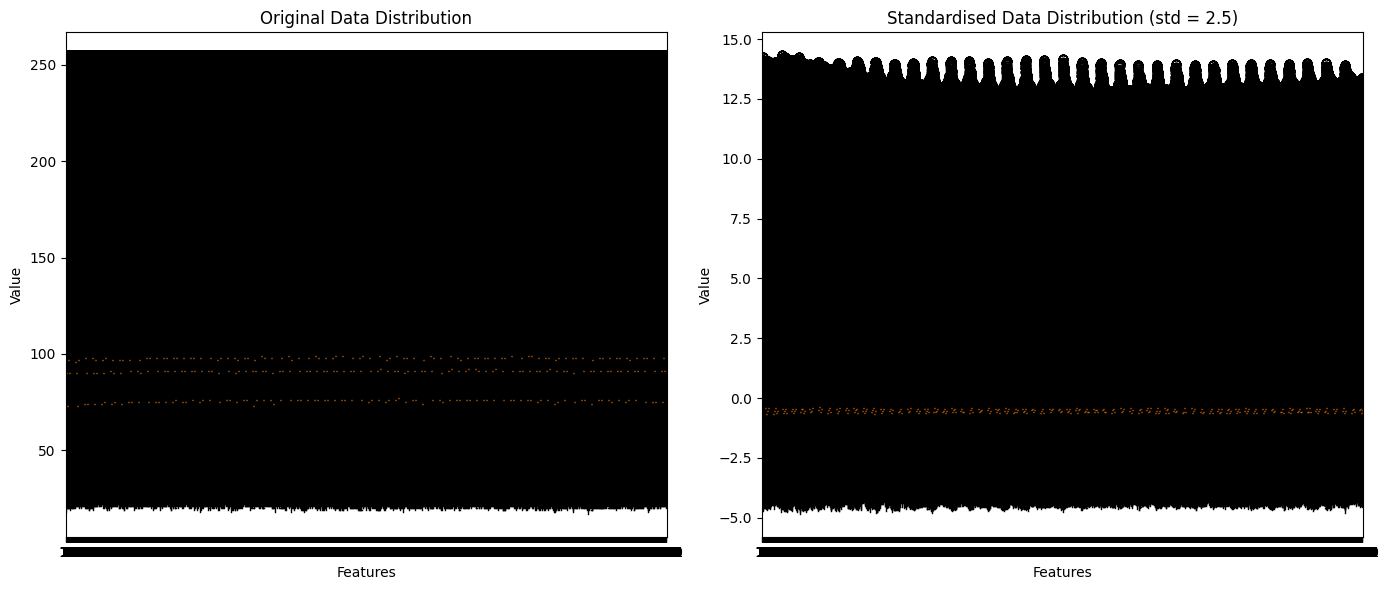

In [12]:
# Example usage
model = COC131()
model.q1()  # Load the data

standardised_x, scaler = model.q2(model.x)
model.visualise_standardisation(model.x, standardised_x)
